# Demo notebook: Facial landmarking


## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Preparations

An auxiliary function to check for an install packages if missing:

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* ImageIO (`imageio` and `imageio-ffmpeg`): for reading images and accessing the webcam
* Scikit-image (`scikit-image`) for some image manipulation
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* Dlib (`dlib`) providing the HOG face detector

In [37]:
%%writefile landmark_demo.yml
name: landmark_demo
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - dlib
  - opencv
  - requests
  - imutils

Overwriting landmark_demo.yml


In [67]:
# import the necessary packages
from imutils import face_utils
import dlib
import cv2
import imageio
import matplotlib.pyplot as plt

# initialize dlib's HOG-based face detector 
hog_detector = dlib.get_frontal_face_detector()

## Face Detection Function 
By Ulf - extended by returning the detected face rectangles - later, the facial landmark predictor uses these rectangles

In [54]:
import numpy as np
from skimage import draw, transform, color
import time

def process(image, detector, upsample_num: int = 1, scale = 1.):
    """Process an image by applying the given detector and
    visually marking detection in that image.

    Arguments
    ---------
    image: np.ndarray
        An array to be interpreted as RGB image (not BGR - the dlib engine
        seems to follow the standard color model!).
    
    detector:
        A dlib detector object.
    
    upsample_num: int
        Number of upsamples during detection. Can be any non-negative
        integer (including 0).
        
    scale: float
        A factor by which the image is scaled prior to detection.
        
    Results
    -------
    image: np.ndarray
        The image with detected faces marked
        
    detections: int
        Number of faces detected
        
    duration: float
        Time (in seconds) needed for detection
    
    rects: the detected rectangled faces
    """
    # Resize image for faster face detection
    scaled_image = transform.rescale(image, scale=(scale, scale, 1),
                                     preserve_range=True).astype(np.uint8)

    # detect faces in the grayscale image
    start = time.time()
    rects = detector(scaled_image, upsample_num)
    end = time.time()

    # decorate the image: loop over the face detections
    for rect in rects:
        # rect is of type <class 'dlib.rectangle'>
        #
        # compute the bounding box of the face and draw it on the
        # original image
        top = max(0, int(rect.top() / scale))
        right = min(image.shape[1], int(rect.right() / scale))
        bottom = min(image.shape[0], int(rect.bottom() / scale))
        left = max(0, int(rect.left() / scale))
        image[(top,top+1, bottom-2, bottom-1), left:right] = (0, 255, 0)
        image[top:bottom, (left, left+1, right-2, right-1)] = (0, 255, 0)

    return image, rects, len(rects), (end-start)

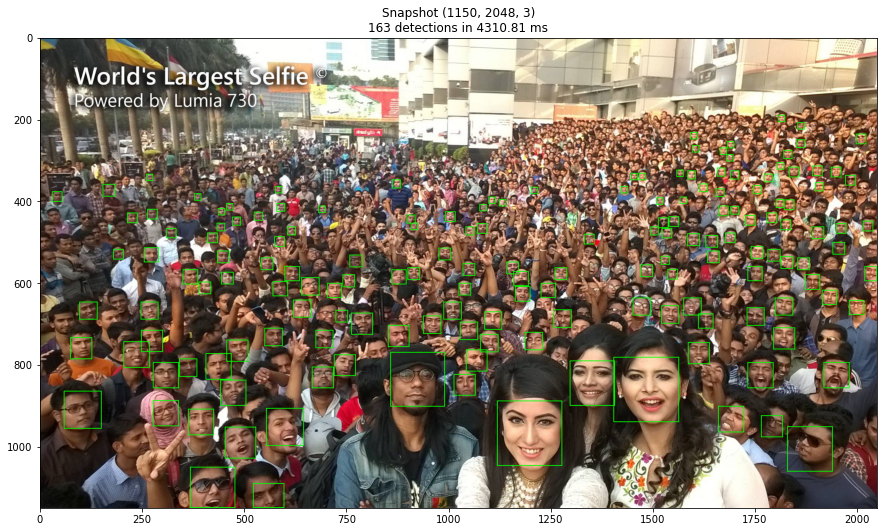

In [63]:
image = imageio.imread('images/LargestSelfie.jpg')   

upsample_num: int = 2
scale: float = 1.0

result_image, rects, detections, duration = \
process(image.copy(), hog_detector, upsample_num=upsample_num, scale=scale)

plt.figure(figsize=(15,15))
plt.title(f"Snapshot {image.shape}\n"
          f"{detections} detection{'' if detections==1 else 's'}"
          f" in {duration*1000:.2f} ms")
plt.imshow(result_image)
plt.show()

## 5 key point landmark predictor (stationary image):

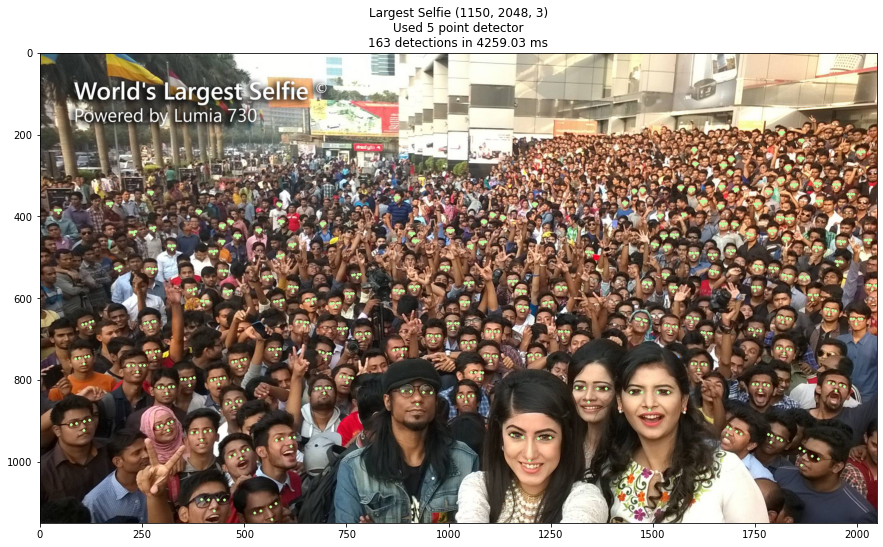

In [71]:
# create the facial landmark predictor
predictor_5 = "shape_predictor_5_face_landmarks.dat"

predictor = dlib.shape_predictor(predictor_5)

# get the input image
# https://4.bp.blogspot.com/-aoMqfIsY5Ls/VHIBk6BQ3dI/AAAAAAAAf3Q/cRV668YRm4w/s1600/10700088_1029155283762368_4785788257713012496_o.jpg
image = imageio.imread('images/LargestSelfie.jpg')   

# Convert it into gray scale (required for the predictor)
gray_Input = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# use the dlib detector to detect faces in the image
#faces = hog_detector(gray_Input, 0)
result_image, rects, detections, duration = \
process(image.copy(), hog_detector, upsample_num=upsample_num, scale=scale)

# loop over those detected faces
for (i, detected) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray_Input, detected)
    shape = face_utils.shape_to_np(shape)

    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 2, (193, 249, 162), 2)

# ----- Plotting -----
plt.figure(figsize=(15,15))
plt.title(f"Largest Selfie {image.shape}\n"
          f"Used 5 point detector\n"
          f"{detections} detection{'' if detections==1 else 's'}"
          f" in {duration*1000:.2f} ms")
plt.imshow(result_image)
plt.imshow(image)

## 68 key point landmark predictor (stationary image):

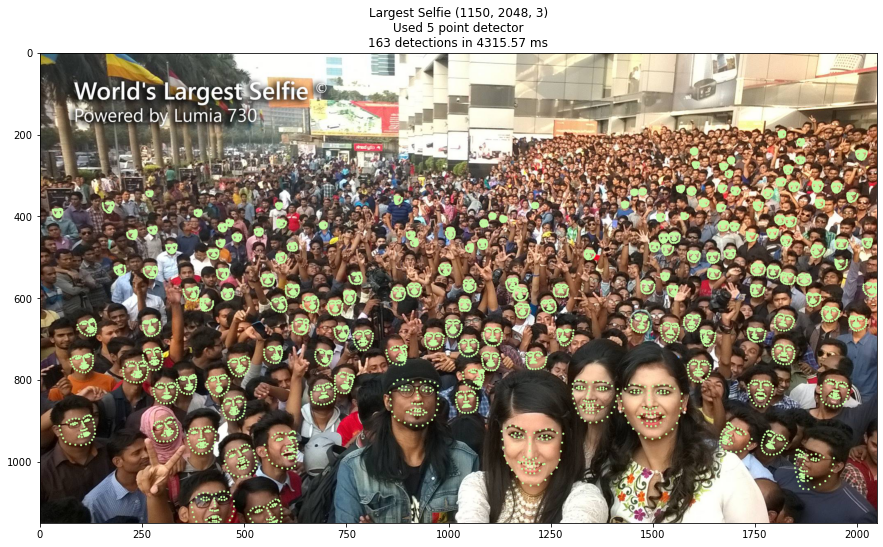

In [70]:
# create the facial landmark predictor
predictor_68 = "shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_68)

# get the input image
# https://4.bp.blogspot.com/-aoMqfIsY5Ls/VHIBk6BQ3dI/AAAAAAAAf3Q/cRV668YRm4w/s1600/10700088_1029155283762368_4785788257713012496_o.jpg
image = imageio.imread('images/LargestSelfie.jpg')   

# Convert it into gray scale (required for the predictor)
gray_Input = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# use the dlib detector to detect faces in the image
#faces = hog_detector(gray_Input, 0)
result_image, rects, detections, duration = \
process(image.copy(), hog_detector, upsample_num=upsample_num, scale=scale)

# loop over those detected faces
for (i, detected) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray_Input, detected)
    shape = face_utils.shape_to_np(shape)

    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (193, 249, 162), 2)

# ----- Plotting -----
plt.figure(figsize=(15,15))
plt.title(f"Largest Selfie {image.shape}\n"
          f"Used 68 point detector\n"
          f"{detections} detection{'' if detections==1 else 's'}"
          f" in {duration*1000:.2f} ms")
plt.imshow(result_image)
plt.imshow(image)

## Facial Landmark Detection with live camera images

In [7]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
predictor_5 = "shape_predictor_5_face_landmarks.dat"
predictor_68 = "shape_predictor_68_face_landmarks.dat"

# Using the dlib face detector
detector = dlib.get_frontal_face_detector()

# Choose between 5 and 68 point predictor here! 
predictor = dlib.shape_predictor(predictor_5)
#predictor = dlib.shape_predictor(predictor_68)


cap = cv2.VideoCapture(0)

while True:
    # load the input
    _, image = cap.read()
    # Convert it into gray scale (required for the predictor)
    gray_Input = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    # use the dlib detector to detect faces in the image
    faces = detector(gray_Input, 0)
    
    # loop over those detected faces
    for (i, detected) in enumerate(faces):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray_Input, detected)
        shape = face_utils.shape_to_np(shape)
    
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (193, 249, 162), 2)
    
    # show the output image with the face detections + facial landmarks
    cv2.imshow("Window", image)
    if cv2.waitKey(1) & 0xFF == ord('q'): # Press q to deactivate camera and close window
        break
        
# Deactivate the camera
cap.release()
# Close all windows
cv2.destroyAllWindows()

# Necessary for mac users to overcome the window closing barrier
for i in range (1,5):
    cv2.waitKey(1)

## $\uparrow$ Press q to stop! $\uparrow$
